In [1]:
# import os, glob, shutil
import os, sys
import cv2
import numpy as np
import uuid
import tensorflow as tf
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from core.imageprep import random_crop, crop_generator, random_crop_batch
from imutils import paths
import itertools

%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
path = "/Volumes/LaCie_DataStorage/PerlmutterData/training/cell_membrane/prepdata"
imgpath = list(paths.list_images(path))
print(imgpath[0])


/Volumes/LaCie_DataStorage/PerlmutterData/training/cell_membrane/prepdata/train/images/cell_membrane/0001.tif


In [3]:
data_gen_args = dict(
                featurewise_center=True,
                featurewise_std_normalization=True,
                horizontal_flip=True,
                vertical_flip=True,
                rotation_range=90.,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.07,
                zoom_range=0.2,
                fill_mode='constant',
                cval=0.,)
seed = 100


In [4]:
image_datagen = ImageDataGenerator(**data_gen_args)
label_datagen = ImageDataGenerator(**data_gen_args)


In [5]:
train_image_generator = image_datagen.flow_from_directory(
    os.path.join(path, 'train/images/'),
    class_mode=None,
    color_mode='grayscale',
    seed=seed)

train_label_generator = label_datagen.flow_from_directory(
    os.path.join(path, 'train/labels'),
    class_mode=None,
    color_mode='grayscale',
    seed=seed)


Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


/Users/michaelshih/anaconda3/envs/tfdl01/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/michaelshih/anaconda3/envs/tfdl01/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


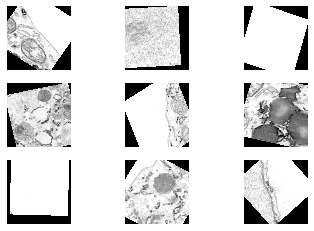

In [6]:
rows = 3
cols = 3
for i in range(9):
    batch = train_image_generator.next()
    image = batch[0].astype('uint8').reshape(256, 256)
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()


In [7]:
valid_image_generator = image_datagen.flow_from_directory(
    os.path.join(path, 'valid/images/'),
    class_mode=None,
    seed=seed)

valid_label_generator = label_datagen.flow_from_directory(
    os.path.join(path, 'valid/labels'),
    class_mode=None,
    seed=seed)


Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [8]:
train_generator = zip(train_image_generator, train_label_generator)
valid_generator = zip(valid_image_generator, valid_label_generator)


In [9]:
from keras.layers import Input, merge
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print ("conv1 shape:",conv1.shape)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print ("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print ("pool1 shape:",pool1.shape)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print ("conv2 shape:",conv2.shape)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print ("conv2 shape:",conv2.shape)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print ("pool2 shape:",pool2.shape)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
print ("conv3 shape:",conv3.shape)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
print ("conv3 shape:",conv3.shape)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print ("pool3 shape:",pool3.shape)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

o_shape = Model(inputs , conv9 ).output_shape
outputHeight = o_shape[1]
outputWidth = o_shape[2]

o = Conv2D(1, 1, activation = 'sigmoid')(conv9)
model = Model(inputs, o)
model.outputWidth = outputWidth
model.outputHeight = outputHeight

model.summary()



W1023 14:44:17.400933 4721710528 deprecation_wrapper.py:119] From /Users/michaelshih/anaconda3/envs/tfdl01/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1023 14:44:17.436030 4721710528 deprecation_wrapper.py:119] From /Users/michaelshih/anaconda3/envs/tfdl01/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1023 14:44:17.441014 4721710528 deprecation_wrapper.py:119] From /Users/michaelshih/anaconda3/envs/tfdl01/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1023 14:44:17.469105 4721710528 deprecation_wrapper.py:119] From /Users/michaelshih/anaconda3/envs/tfdl01/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_po

NameError: name 'UpSampling2D' is not defined